# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import scipy

In [2]:
PATH_TO_DATA = r"./data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))
        
    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        scores_w = [self.score(w,w0) for w0 in self.word2vec] #all the scores between w and the other words in word2vec

        if not ((min(scores_w)== 0) and (max(scores_w)==0)):
            index_best_words = (np.argsort(scores_w)[len(scores_w)-K:len(scores_w)])
            list_best_words_desc = [list(self.word2vec.keys())[i] for i in index_best_words]#in the reverse order
            return(list_best_words_desc[::-1])
        else:
            print(str(w)+' not in the initial dictionnary!')
            
    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        if (w1 in self.word2vec)and(w2 in self.word2vec):
            score_w1 = self.word2vec[w1]
            score_w2 = self.word2vec[w2]
            return np.dot(score_w1, score_w2.T)/(np.linalg.norm(score_w1)*np.linalg.norm(score_w2))
        else:#if both w1 and w2 are not in the word2vec.keys()
            return 0

   

In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=55000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 55000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7775108541288561
germany berlin 0.7420295235998392
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'Dog', 'doggie']
['dogs', 'dog', 'Dogs', 'doggies', 'canines']
['paris', 'france', 'Paris', 'london', 'berlin']
['germany', 'europe', 'german', 'berlin', 'france']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
        self.idf = None
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        j = 0
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                list_words = [w for w in sent if w in self.w2v.word2vec]
                if list_words:
                    embeddings = [self.w2v.word2vec[w] for w in list_words]
                else:
                    embeddings = np.full_like(np.arange(300, dtype=int), np.nan, dtype=np.double)
                m = np.nanmean(embeddings, axis=0)
            else:
                # idf-weighted mean of word vectors
                list_words = [w for w in sent if w in self.w2v.word2vec]
                if list_words:
                    embeddings = [self.idf[w] * self.w2v.word2vec[w] for w in list_words]
                else:
                    embeddings = np.full_like(np.arange(300, dtype=int), np.nan, dtype=np.double)
                m = np.nanmean(embeddings, axis=0)
            sentemb.append(m)
        return np.vstack(sentemb)


    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        
#         keys = self.encode(sentences, idf)
#         query = self.encode([s], idf)[0]
        
        scores = [self.score(sent, s, idf) for sent in sentences]
        scores_index = np.argsort(scores)[::-1]
        
        # The most similar sentence is the one with second best score (self-similarity is always 1)
        most_similar_sentences_ = [sentences[scores_index[i]] for i in range(1, K + 1)]
            
        S = ' '.join(s)
        print(str(K)+' most similar sentences to '+ str(' '.join(s))+' :')
        for sent in most_similar_sentences_:
            print(str(' '.join(sent)))
        
        return most_similar_sentences_


    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        enc_s1 = self.encode([s1], idf).flatten()
        enc_s2 = self.encode([s2], idf).flatten()
        
        cond = ((np.linalg.norm(enc_s1)!=0) and ((np.linalg.norm(enc_s2)!=0)))
        score_ = np.dot(enc_s1, enc_s2.T)/(np.linalg.norm(enc_s1)*np.linalg.norm(enc_s2)) if cond else 0
        
        return score_
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1 
        
        for word in idf:
            idf[word]= max(1, np.log10(len(sentences) / (idf[word])))
            
        self.idf = idf


In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=50000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
with open(os.path.join(PATH_TO_DATA,'sentences.txt')) as f:
    sentences = f.readlines()
    
sentences = [sent.split() for sent in sentences]

# Build idf scores for each word
s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
# s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
# s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13])
print('\n')
s2v.most_similar(sentences[10], sentences)  # BoV-mean
print('The score between sentence 7 and 13 is ' +str(s2v.score(sentences[7],sentences[13])))
print('\n')
s2v.most_similar(sentences[10], sentences, True)  # BoV-idf
print('The score between sentence 7 and 13 is '+str(s2v.score(sentences[7],sentences[13], True)))


Loaded 50000 pretrained word vectors


5 most similar sentences to 1 smiling african american boy . :
an african american man smiling .
a little african american boy and girl looking up .
an african american in sunglasses and a white tee-shirt smiles .
an afican american woman standing behind two small african american children .
an african american man is sitting .
The score between sentence 7 and 13 is 0.5726258859719607


5 most similar sentences to 1 smiling african american boy . :
an african american man smiling .
an african american man is sitting .
a little african american boy and girl looking up .
an afican american woman standing behind two small african american children .
an african american woman braiding another african american woman 's hair , while sitting in a white chair .
The score between sentence 7 and 13 is 0.4751450875368781


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

fr_txt = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)
eng_txt = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

words_fr_txt = set(fr_txt.word2vec.keys())
words_eng_txt = set(eng_txt.word2vec.keys())
    
identical_words = words_fr_txt & words_eng_txt #bilingual words
    
X = np.vstack([fr_txt.word2vec[w] for w in identical_words])
Y = np.vstack([eng_txt.word2vec[w] for w in identical_words])

In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

import scipy.linalg
    
U, s, V = scipy.linalg.svd(np.dot(Y.T, X)) #Singular Value Decomposition
    
W = np.dot(U, V)

In [25]:
class Translation():
    def __init__(self, w2v_lang1, w2v_lang2, nmax=100000):

        self.w2v_lang1 = w2v_lang1.word2vec
        self.w2v_lang2 = w2v_lang2.word2vec

        self.word2id_lang1 = dict.fromkeys(self.w2v_lang1.keys())
        self.word2id_lang2 = dict.fromkeys(self.w2v_lang2.keys())
        
        self.id2word_lang1 = {v: k for k, v in self.word2id_lang1.items()}
        self.id2word_lang2 = {v: k for k, v in self.word2id_lang2.items()}
        
        self.W = W
        
    def Translate(self, w, K=5, language='French'):

        if language=='French':
            W1 = self.W
            id2word = self.id2word_lang2
            w2v = self.w2v_lang1
            w2v_foreign = self.w2v_lang2
            
        elif language=='English':
            W1 = np.linalg.inv(self.W)
            id2word = self.id2word_lang1
            w2v = self.w2v_lang2
            w2v_foreign = self.w2v_lang1
        
        scores = [self.score(np.dot(W1,w2v[w]), w2) for w2 in w2v_foreign.values()]
        index_best_words = (np.argsort(scores)[len(scores)-K:len(scores)])
        list_best_words_desc = [list(w2v_foreign.keys())[i] for i in index_best_words]#in the reverse order
        return(list_best_words_desc[::-1])

    def score(self, w1, w2):
        if (np.linalg.norm(w1)*np.linalg.norm(w2))!=0:
            return w1.dot(w2)/(np.linalg.norm(w1)*np.linalg.norm(w2))
        else:
            return 0


trad = Translation(fr_txt, eng_txt)

print('---from French to English---')
fr_words = ["ordinateur", "heure", "aimer"]
for w in fr_words:
    t = trad.Translate(w, language='French')
    print("5 best translations of {} are: {}".format(w, " ".join(t)))
print('\n')
print('---from English to French---')
en_words = ["computer", "apple", "president"]
for w in en_words:
    t = trad.Translate(w, language='English')
    print("5 best translations of {} are: {}".format(w, " ".join(t)))

---from French to English---
5 best translations of ordinateur are: computers computer mainframe workstation programmable
5 best translations of heure are: minutes hours hour hrs mins
5 best translations of aimer are: love nous regrets affection affections


---from English to French---
5 best translations of computer are: computer informatique ordinateurs ordinateur computing
5 best translations of apple are: apple microsoft macintosh iphone intel
5 best translations of president are: président présidence présidents president coprésident


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

train_file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
dev_file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'))
test_file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'))
    
def load_file(file, is_test = False):
    A = []
    categorical = []                
    if not is_test:
        for l in file:
            A.append(l.split()[1:])
            categorical.append(l.split()[0])
        categorical = [int(categorical[i]) for i in range(len(categorical))]
        return A, categorical
    else:
        for l in file:
            A.append(l.split())
        return A

X_train, Y_train = load_file(train_file)
X_dev, Y_dev = load_file(dev_file)
X_test = load_file(test_file, is_test = True)

In [12]:
# 2 - Encode sentences with the BoV model above

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=55000)
s2v = BoV(w2v)

s2v.build_idf(X_train+X_dev+X_test)

#without idf
Xtrain_encode = s2v.encode(X_train)
Xdev_encode = s2v.encode(X_dev)
Xtest_encode = s2v.encode(X_test)

#with idf
Xtrain_encode_idf = s2v.encode(X_train, idf=True)
Xdev_encode_idf = s2v.encode(X_dev, idf=True)
Xtest_encode_idf = s2v.encode(X_test, idf=True)

Loaded 55000 pretrained word vectors


In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

acc_list_train = []
acc_list_dev =[]
for C in np.linspace(0.01,0.3, 20):
    logistic_model = LogisticRegression(C=C,max_iter=1000)#By default it's penality l2
    logistic_model.fit(Xtrain_encode,Y_train)

    pred_train = logistic_model.predict( Xtrain_encode)
    pred_dev = logistic_model.predict(Xdev_encode)
    
    acc_list_train.append(accuracy_score(Y_train,pred_train))
    acc_list_dev.append(accuracy_score(Y_dev,pred_dev))
    
import matplotlib.pyplot as plt
plt.plot(np.linspace(0.01,0.3, 20), acc_list_train, label = 'Train')
plt.plot(np.linspace(0.01,0.3, 20), acc_list_dev, label = 'Test')
plt.xlabel('C')
plt.ylabel('accuracy score')
plt.title('accuracy score with C')
plt.legend()
plt.show()

logistic_model = LogisticRegression(C=0.3,max_iter=1000)#By default it's penality l2
logistic_model.fit(Xtrain_encode,Y_train)

pred_train = logistic_model.predict( Xtrain_encode)
pred_dev = logistic_model.predict(Xdev_encode)

print('-------Without idf--------')
print('accuracy score for train is ', accuracy_score(Y_train,pred_train))
print('accuracy score for dev is', accuracy_score(Y_dev,pred_dev))


logistic_model_idf = LogisticRegression(C=0.04,max_iter=1000)#By default it's penality l2
logistic_model_idf.fit(Xtrain_encode_idf,Y_train)

pred_train_idf = logistic_model_idf.predict(Xtrain_encode_idf)
pred_dev_idf = logistic_model_idf.predict(Xdev_encode_idf)

print('-------With idf--------')
print('accuracy score for train is ', accuracy_score(Y_train,pred_train_idf))
print('accuracy score for dev is', accuracy_score(Y_dev,pred_dev_idf))

<Figure size 640x480 with 1 Axes>

-------Without idf--------
accuracy score for train is  0.46769662921348315
accuracy score for dev is 0.4250681198910082
-------With idf--------
accuracy score for train is  0.4621956928838951
accuracy score for dev is 0.4268846503178928


In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.


lines = '\n'.join([str(c) for c in logistic_model.predict(Xtest_encode)])
with open(os.path.join('.',r'logreg_bov_y_test_sst.txt'),'w') as f:
    f.writelines(lines)


In [15]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)
from xgboost import XGBClassifier
    
xgb = XGBClassifier() 
xgb.fit(Xtrain_encode, Y_train,eval_set=[(Xdev_encode, Y_dev)], early_stopping_rounds=20, verbose = False)
pred = xgb.predict(Xdev_encode)
print('accuracy score with XGBoost is '+str(accuracy_score(Y_dev, pred)))

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=3)
X_lda = lda.fit(Xtrain_encode, Y_train)
pred = X_lda.predict(Xdev_encode)
print('accuracy score with LDA is '+str(accuracy_score(Y_dev, pred)))

lines = '\n'.join([str(c) for c in X_lda.predict(Xtest_encode)])
with open(os.path.join('.',r'lda_bov_y_test_sst.txt'),'w') as f:
    f.writelines(lines)
    
#Linear model perform better than non linear models

accuracy score with XGBoost is 0.40054495912806537
accuracy score with LDA is 0.4332425068119891


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [16]:
import keras

Using TensorFlow backend.


In [17]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "./data/"
train_file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
dev_file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'))
test_file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'))

X_train, Y_train = load_file(train_file)
X_dev, Y_dev = load_file(dev_file)
X_test = load_file(test_file, is_test = True)


In [18]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

from keras.preprocessing import text
from keras.utils import to_categorical

w1 = set([s for sent in (X_train+X_dev+X_test) for s in sent ])
vocab_size = len(w1)

X_train_one_hot = [text.one_hot(' '.join(x),vocab_size) for x in X_train]
X_dev_one_hot = [text.one_hot(' '.join(x),vocab_size) for x in X_dev]
X_test_one_hot = [text.one_hot(' '.join(x),vocab_size) for x in X_test]


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [19]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences


X_train_pad = pad_sequences(X_train_one_hot, maxlen= 40)
X_dev_pad = pad_sequences(X_dev_one_hot, maxlen= 40)
X_test_pad = pad_sequences(X_test_one_hot, maxlen= 40)

## 4.2 - Design and train your model

In [20]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW



from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, SpatialDropout1D

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = vocab_size  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(nhid, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(n_classes, activation='softmax'))


In [21]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW
loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'nadam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          625216    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 650,373
Trainable params: 650,373
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 11s 1ms/step - loss: 1.5773 - acc: 0.2621 - val_loss: 1.5708 - val_acc: 0.2534
Epoch 2/6
8544/8544 [==============================] - 9s 1ms/step - loss: 1.5646 - acc: 0.2864 - val_loss: 1.5620 - val_acc: 0.3079
Epoch 3/6
8544/8544 [==============================] - 10s 1ms/step - loss: 1.5361 - acc: 0.3143 - val_loss: 1.5166 - val_acc: 0.3433
Epoch 4/6
8544/8544 [==============================] - 10s 1ms/step - loss: 1.4882 - acc: 0.3490 - val_loss: 1.4814 - val_acc: 0.3569
Epoch 5/6
8544/8544 [==============================] - 10s 1ms/step - loss: 1.4454 - acc: 0.3711 - val_loss: 1.4581 - val_acc: 0.3542
Epoch 6/6
8544/8544 [==============================] - 10s 1ms/step - loss: 1.3956 - acc: 0.3960 - val_loss: 1.4465 - val_acc: 0.3515
---Plot---


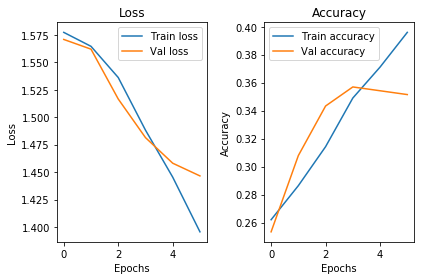

In [22]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
import matplotlib.pyplot as plt
from IPython.display import clear_output

bs = 64
n_epochs = 6

Y_train_categorical = to_categorical(Y_train)
Y_dev_categorical = to_categorical(Y_dev)
history = model.fit(X_train_pad, Y_train_categorical, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev_pad, Y_dev_categorical), verbose =True)
print('---Plot---')
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(history.history["loss"], label="Train loss")
ax1.plot(history.history["val_loss"], label="Val loss")
ax1.set_title("Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(history.history["acc"], label="Train accuracy")
ax2.plot(history.history["val_acc"], label="Val accuracy")
ax2.set_title("Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.tight_layout()
plt.show()

In [23]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
pred_test_one = model.predict(X_test_pad)
pred_test = [np.argmax(pred) for pred in pred_test_one]
lines = '\n'.join([str(c) for c in pred_test])
with open(os.path.join('.',r'logreg_lstm_y_test_sst.txt'),'w') as f:
    f.writelines(lines)

## 4.3 -- innovate !

In [24]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
from keras.layers import Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

train_file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
dev_file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'))
test_file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'))


def load_wordvec(fname, nmax):
    word2vec = {}
    with io.open(fname, encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            word, vec = line.split(' ', 1)
            word2vec[word] = np.fromstring(vec, sep=' ')
            if i == (nmax - 1):
                break
    return word2vec

w2v = load_wordvec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)

def load_file(file, is_test = False):
    A = []
    categorical = []                
    if not is_test:
        for l in file:
            A.append(l[1:])
            categorical.append(l.split()[0])
        categorical = [int(categorical[i]) for i in range(len(categorical))]
        return A, categorical
    else:
        for l in file:
            A.append(l)
        return A

X_train, Y_train = load_file(train_file)
X_dev, Y_dev = load_file(dev_file)
X_test = load_file(test_file, is_test = True)
    
#Pretrain of lookup tables and filtering the data
print('---filtering---')
X_train_token = [text.text_to_word_sequence(x) for x in X_train]
X_dev_token = [text.text_to_word_sequence(x) for x in X_dev]
X_test_token = [text.text_to_word_sequence(x) for x in X_test]

interec = set()
for x in X_train_token:
    for y in x:
        interec.add(y)
for x in X_dev_token:
    for y in x:
        interec.add(y)
for x in X_test_token:
    for y in x:
        interec.add(y)        

print('Check 1: size of intersect of words in Train, Test and Dev is '+str(len(list(interec))))

#For each word map it to a number in a dictionnary
dict_={}
count=0
for x in list(interec):
    dict_[count] = str(x)
    count += 1
            

#Mapping the words of the dataFrames to the id of the dictionnary
dict_inv = {v: k for k, v in dict_.items()}
def Mapping(sent):
    X = []
    for s in sent:
        mapp = []
        for x in s:
            mapp.append(dict_inv.get(x))
        X.append(mapp)
    return X

X_train_pad = pad_sequences(Mapping(X_train_token), maxlen = 60)
X_dev_pad = pad_sequences(Mapping(X_dev_token), maxlen = 60)
X_test_pad = pad_sequences(Mapping(X_test_token), maxlen= 60)

print('---Creating Embedding Matrix---')
#Mapping between the id of dictionnary and the embedding
Embedding_Matrix=[]
for i in range(count):
    Embedding_Matrix.append(w2v.get(dict_[i], np.zeros(300)))
Embedding_Matrix = np.array(Embedding_Matrix)
print('Check 2: Embedding Matrix size', Embedding_Matrix.shape)

print('---Train----')
model = Sequential()
model.add(Embedding(Embedding_Matrix.shape[0], 300, trainable = False, weights = [Embedding_Matrix]))
model.add(Bidirectional(LSTM(32, dropout_W=0.4, recurrent_dropout=0.4))) #bidirectional layer
model.add(Dense(n_classes, activation='softmax'))

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)


bs = 64
n_epochs = 6

history = model.fit(X_train_pad, to_categorical(Y_train), 
                    batch_size=bs,
                    epochs=n_epochs, 
                    validation_data=(X_dev_pad, to_categorical(Y_dev)), verbose=True)

print('---Predict---')
pred_test_one = model.predict(X_test_pad)
pred_test = [np.argmax(pred) for pred in pred_test_one]
print('---Saving The File---')
lines = '\n'.join([str(c) for c in pred_test])
with open(os.path.join('.',r'bilstm_dense_y_test_sst.txt'),'w') as f:
    f.writelines(lines)
print('---End---')

---filtering---
Check 1: size of intersect of words in Train, Test and Dev is 17839
---Creating Embedding Matrix---
Check 2: Embedding Matrix size (17839, 300)
---Train----
Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 25s 3ms/step - loss: 1.5299 - acc: 0.3082 - val_loss: 1.3993 - val_acc: 0.3806
Epoch 2/6
8544/8544 [==============================] - 21s 2ms/step - loss: 1.3836 - acc: 0.3910 - val_loss: 1.3274 - val_acc: 0.4114
Epoch 3/6
8544/8544 [==============================] - 21s 2ms/step - loss: 1.3432 - acc: 0.4129 - val_loss: 1.3131 - val_acc: 0.4205
Epoch 4/6
8544/8544 [==============================] - 20s 2ms/step - loss: 1.3137 - acc: 0.4260 - val_loss: 1.2746 - val_acc: 0.4151
Epoch 5/6
8544/8544 [==============================] - 20s 2ms/step - loss: 1.2909 - acc: 0.4397 - val_loss: 1.2671 - val_acc: 0.4233
Epoch 6/6
8544/8544 [==============================] - 22s 3ms/step - loss: 1.2736 - acc: 0.4496 - val_loss: 